In [1]:
import os, shutil, importlib
import utils; importlib.reload(utils)

# os.environ["CUDA_VISIBLE_DEVICES"]=''

import numpy as np
import pandas as pdp
import tensorflow as tf

from glob import glob
from PIL import Image
from os.path import join as jp

from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image

from IPython.display import FileLink


%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

Using TensorFlow backend.


Construct directory structure

In [2]:
path = '../data/dogscats/'
utils.struct_dir(path, ['cat', 'dog'])

Directory structure already exists


In [3]:
# path = '../data/dogscats/'
path = '../data/dogscats/sample/'
path_test = path + 'test'
path_train = path + 'train'
path_valid = path + 'valid'
path_submit = '../data/dogscats/models/vgg16/submissions/'
path_checkpoint = '../data/dogscats/models/vgg16/checkpoints/'
path_results = '../data/dogscats/models/vgg16/results/'

Build classifier using pretrained VGG16 model

In [4]:
import vgg16; importlib.reload(vgg16)
from vgg16 import Vgg16

## Finetune model for cats and dogs


- Grab a few batches from train and valid
- Finetune using training batches
- Fit model with training and valid batches over 1 epoch

In [5]:
batch_size = 8

In [6]:
vgg = Vgg16()

Loading model weights


In [7]:
batches = utils.get_batches(path_train, batch_size=batch_size)
batches_valid = utils.get_batches(path_valid, batch_size=batch_size)

Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
vgg.finetune(batches)

In [9]:
callbacks = [ModelCheckpoint(path_checkpoint+'weights.hdf5', verbose=1,
                             save_best_only=True)]
vgg.fit(batches, batches_valid=batches_valid, nb_epoch=1, callbacks=callbacks)

Epoch 1/1
100/100 [==============================] - 50s - loss: 0.6129 - acc: 0.8100 - val_loss: 0.2425 - val_acc: 0.8900


## Investigate some images

In [2]:
# vgg = Vgg16()

In [ ]:
batches = utils.get_batches(path+'train', batch_size=4)

In [ ]:
imgs, labels = batches.__next__()

In [ ]:
utils.plot_imgs(imgs, rows=1, titles=labels)

In [ ]:
vgg.predict(imgs, details=True)

## Generate Predictions

In [10]:
batch_size = 8

In [52]:
batches_test, preds_test = vgg.test(path+'test', batch_size=batch_size)

Found 111 images belonging to 1 classes.


In [53]:
np.save(path_results+'filenames_test', batches_test.filenames)
np.save(path_results+'preds_test', preds_test)

Check while column in preds_test is dogs vs cats

In [11]:
print(preds_test[1])
Image.open(path_test+'/'+batches_test.filenames[1])

NameError: name 'preds_test' is not defined

## Validate Predictions

Look at a few examples of a few different image categories
- Random correct labels
- Random incorrect labels
- Most correct labels
- Most incorrect labels
- Most uncertain labels (prob closest to 0.5)
This is a good technique to use when trying to debug/improve a model

In [12]:
batches_valid, preds_valid = vgg.test(path_valid, batch_size=8)

Found 100 images belonging to 2 classes.


In [13]:
np.save(path_results+'filenames_valid', batches_valid.filenames)
np.save(path_results+'preds_valid', preds_valid)

In [14]:
pred_probs = preds_valid[:, 0]
pred_labels = np.round(1 - pred_probs)
true_labels = batches_valid.classes

In [15]:
def plot_imgs_idx(idx, titles):
    utils.plot_imgs(
    [image.load_img(jp(path_valid, batches_valid.filenames[i])) for i in idx],
    titles=titles)
nimgs = 4

A few random correct labels

Found 89 correct labels


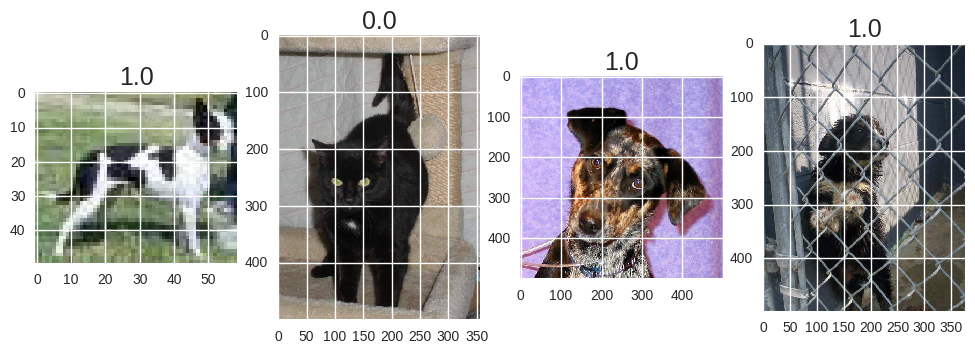

In [16]:
corr_labels = np.where(pred_labels == true_labels)[0]
print('Found %d correct labels' % len(corr_labels))
idx = np.random.permutation(corr_labels)[:nimgs]
plot_imgs_idx(idx, pred_labels[idx])

A few incorrect labels

Found 11 incorrect labels


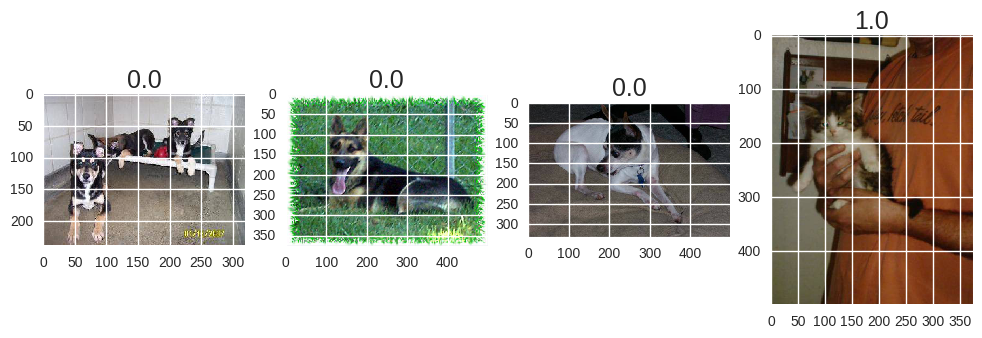

In [17]:
corr_labels = np.where(pred_labels != true_labels)[0]
print('Found %d incorrect labels' % len(corr_labels))
idx = np.random.permutation(corr_labels)[:nimgs]
plot_imgs_idx(idx, pred_labels[idx])

Most correct labels

Taking 4 highest confidence predictions


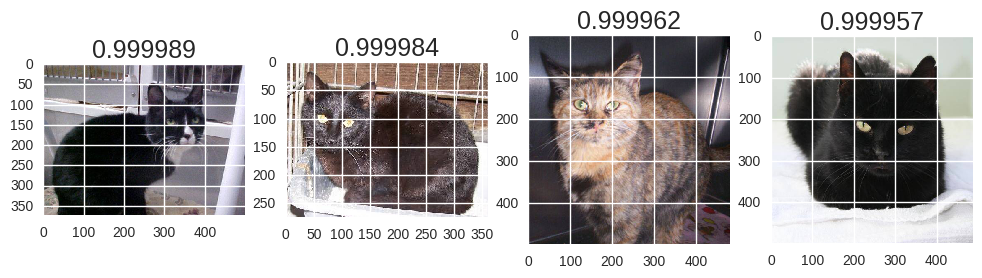

In [18]:
corr_cats = np.where((pred_labels == 0) & (pred_labels == true_labels))[0]
idx = np.argsort(-pred_probs[corr_cats])[:nimgs]
print('Taking %d highest confidence predictions' % nimgs)
plot_imgs_idx(corr_cats[idx], pred_probs[corr_cats][idx])

Taking 4 highest confidence predictions


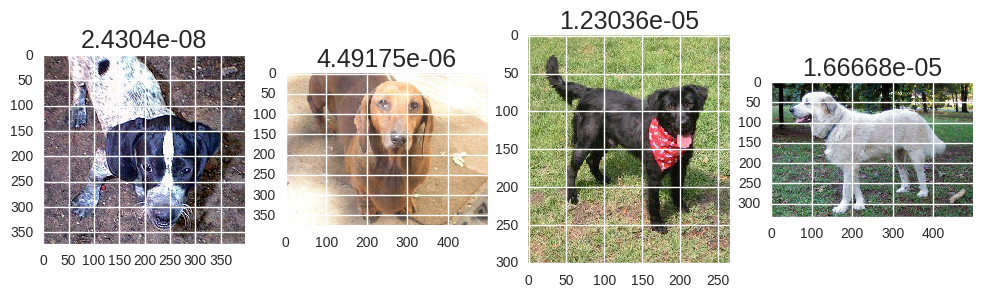

In [19]:
corr_dogs = np.where((pred_labels == 1) & (pred_labels == true_labels))[0]
idx = np.argsort(pred_probs[corr_dogs])[:nimgs]
print('Taking %d highest confidence predictions' % nimgs)
plot_imgs_idx(corr_dogs[idx], pred_probs[corr_dogs][idx])

Images with high confidence but incorrect

Predicted dog, but actually cat


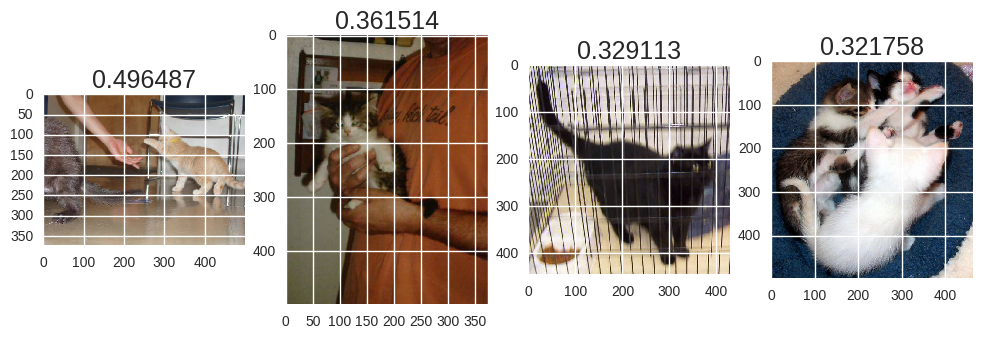

In [20]:
inc = np.where((pred_labels == 1) & (pred_labels != true_labels))[0]
idx = np.argsort(-pred_probs[inc])[:nimgs]
print('Predicted dog, but actually cat')
plot_imgs_idx(inc[idx], pred_probs[inc][idx])

Predicted cat, but actually dog


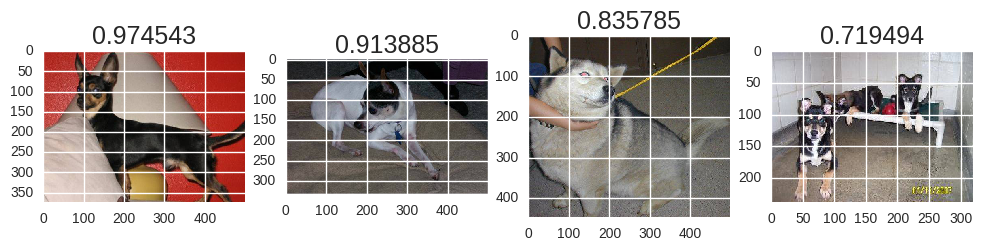

In [21]:
#### Does not have any in sample
inc = np.where((pred_labels == 0) & (pred_labels != true_labels))[0]
idx = np.argsort(-pred_probs[inc])[:nimgs]
print('Predicted cat, but actually dog')
plot_imgs_idx(inc[idx], pred_probs[inc][idx])

Most uncertain images

Most uncertain predicitons


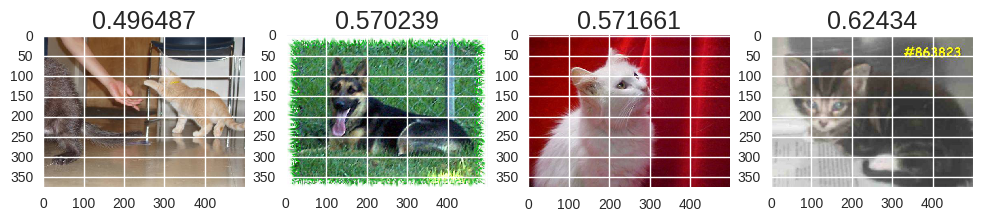

In [22]:
idx = np.argsort(np.abs(pred_probs - 0.5))[:nimgs]
print('Most uncertain predicitons')
plot_imgs_idx(idx, pred_probs[idx])

Plot confusion matrix

In [23]:
from sklearn.metrics import confusion_matrix

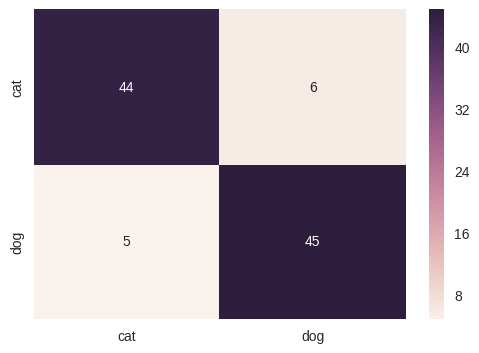

In [24]:
cm = confusion_matrix(true_labels, pred_labels)
utils.plot_conf_matrix(cm, labels=['cat', 'dog'])

# Create Submission

This competition uses log-loss as a metric, so we need to clip values that are too confident (~1, ~0)

In [25]:
utils.create_submit(batches_test, preds_test[:, 1], clip=(0, 1), 
                    fname=path_submit+'dogscats_1.csv')

NameError: name 'batches_test' is not defined

In [ ]:
# FileLink()